In [58]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

warnings.filterwarnings('ignore')
%matplotlib inline


# Fix multiprocessing for Windows (safe to use on other OS too)
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

In [59]:
import torch


In [60]:
# Load the dataset
labitems = pd.read_csv('D_LABITEMS.csv.gz')

labitems.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


In [61]:
# Preview data

print(labitems.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      753 non-null    int64 
 1   ITEMID      753 non-null    int64 
 2   LABEL       753 non-null    object
 3   FLUID       753 non-null    object
 4   CATEGORY    753 non-null    object
 5   LOINC_CODE  585 non-null    object
dtypes: int64(2), object(4)
memory usage: 35.4+ KB
None


In [62]:
print("Missing values:\n", labitems.isnull().sum())
print("Duplicates:", labitems.duplicated().sum())


Missing values:
 ROW_ID          0
ITEMID          0
LABEL           0
FLUID           0
CATEGORY        0
LOINC_CODE    168
dtype: int64
Duplicates: 0


In [63]:
# Drop duplicates
labitems.drop_duplicates(inplace=True)

# Drop rows with missing LABEL or FLUID (essential dictionary data)
labitems_cleaned = labitems.dropna(subset=['LABEL', 'FLUID'])

# Optional: fill missing LOINC_CODE with a placeholder
labitems_cleaned['LOINC_CODE'] = labitems_cleaned['LOINC_CODE'].fillna('UNKNOWN')

# Encode categorical columns
for col in ['LABEL', 'FLUID', 'CATEGORY', 'LOINC_CODE']:
    labitems_cleaned[col] = labitems_cleaned[col].astype('category').cat.codes

# Save cleaned version
labitems_cleaned.to_csv('labitems_cleaned.csv', index=False)


In [64]:
# Load cleaned data
labitems_cleaned = pd.read_csv('labitems_cleaned.csv')

# Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(labitems_cleaned)

# Initialize synthesizer
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=300,
    batch_size=100,
    pac=10
)
# Fit the model
synthesizer.fit(labitems_cleaned)

# Generate synthetic samples
synthetic_labitems = synthesizer.sample(num_rows=labitems_cleaned.shape[0])
synthetic_labitems.to_csv('synthetic_labitems.csv', index=False)


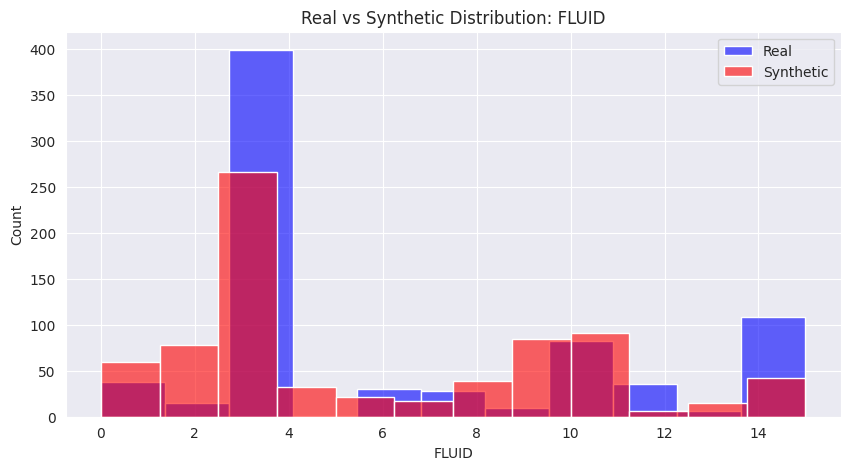

In [65]:
#  Compare distributions
column = 'FLUID'

plt.figure(figsize=(10, 5))
sns.histplot(labitems_cleaned[column], color='blue', label='Real', kde=False, alpha=0.6)
sns.histplot(synthetic_labitems[column], color='red', label='Synthetic', kde=False, alpha=0.6)
plt.legend()
plt.title(f'Real vs Synthetic Distribution: {column}')
plt.xlabel(column)
plt.ylabel('Count')
plt.show()


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Try predicting CATEGORY from LABEL, FLUID
features = ['LABEL', 'FLUID']
target = 'CATEGORY'
labitems_cleaned['target'] = (labitems_cleaned[target] > labitems_cleaned[target].median()).astype(int)
synthetic_labitems['target'] = (synthetic_labitems[target] > labitems_cleaned[target].median()).astype(int)

# Encode again in case
for col in features:
    labitems_cleaned[col] =labitems_cleaned[col].astype('category').cat.codes
    synthetic_labitems[col] = synthetic_labitems[col].astype('category').cat.codes

X_real = labitems_cleaned[features]
y_real = labitems_cleaned[target]

X_synth = synthetic_labitems[features]
y_synth = synthetic_labitems[target]

# Train/test split and fit
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_synth, y_synth, test_size=0.3)

model_real = RandomForestClassifier().fit(Xr_train, yr_train)
model_synth = RandomForestClassifier().fit(Xs_train, ys_train)

real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))
synth_acc = accuracy_score(ys_test, model_synth.predict(Xs_test))

print(f"Accuracy on real: {real_acc:.2f}")
print(f"Accuracy on synthetic: {synth_acc:.2f}")


Accuracy on real: 0.60
Accuracy on synthetic: 0.38


In [67]:
from sdv.single_table import TVAESynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and target (from D_CPT structure)
features = ['LABEL', 'FLUID']
target_col = 'CATEGORY'

# Create binary classification target
labitems_cleaned['target'] = (labitems_cleaned[target_col] > labitems_cleaned[target_col].median()).astype(int)

# Regenerate metadata (if needed)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(labitems_cleaned.drop(columns=['target']))

# Fit TVAE (drop target column before fitting)
vae_synthesizer = TVAESynthesizer(metadata=metadata, epochs=30)
vae_synthesizer.fit(labitems_cleaned.drop(columns=['target']))

# Sample synthetic data
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

# Add target to synthetic data
synthetic_data_vae['target'] = (synthetic_data_vae[target_col] > labitems_cleaned[target_col].median()).astype(int)

# Encode categorical features
for col in features:
    labitems_cleaned[col] = labitems_cleaned[col].astype('category').cat.codes
    synthetic_data_vae[col] = synthetic_data_vae[col].astype('category').cat.codes

# Train/test split
X_real = labitems_cleaned[features]
y_real = labitems_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

# Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Results
print(f"Model accuracy on REAL D_CPT data: {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC D_CPT: {vae_acc:.2f}")


Model accuracy on REAL D_CPT data: 1.00
Model accuracy on VAE SYNTHETIC D_CPT: 1.00


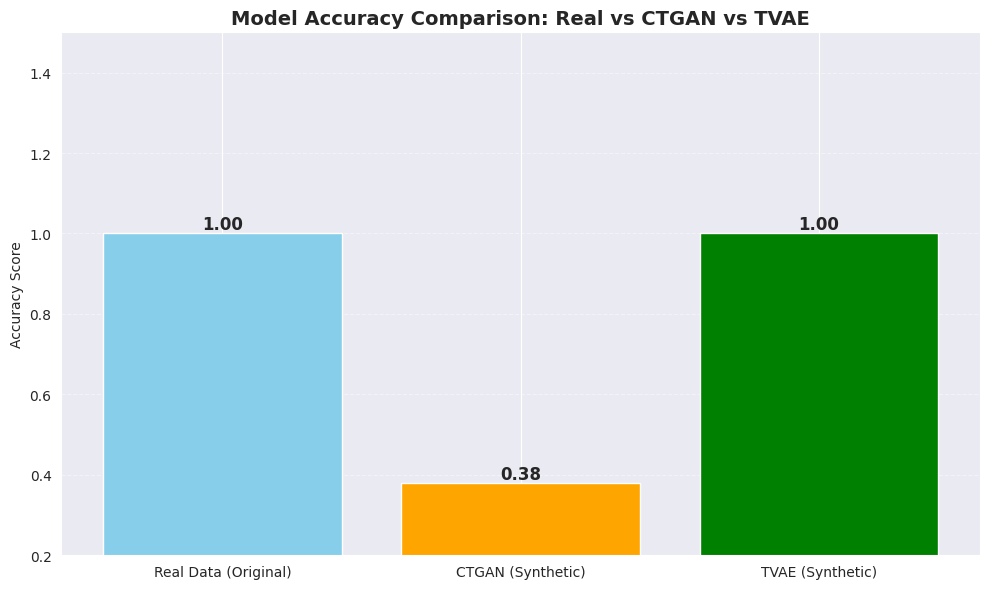

In [68]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = synth_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()